In [1]:
import numpy as np
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Input

import matplotlib.pyplot as plt
import tifffile

2023-08-22 09:59:24.020513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 09:59:24.683052: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [12]:
img = plt.imread('../data/tremor1/preview/quick-look.png')

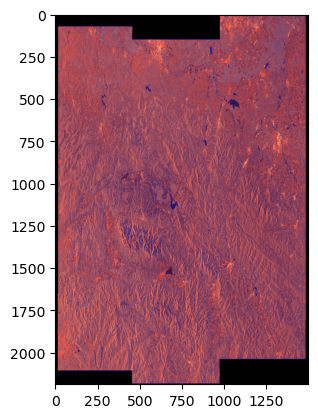

In [13]:
plt.imshow(img)

In [15]:
img = tifffile.imread('../data/tremor1/measurement/s1a-iw2-slc-vh-20151016t045256-20151016t045321-008173-00b7bd-002.tiff')

In [18]:
img

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)

In [2]:
def siamese_network(input_image):
#    print('Inside Siamese')
    base_model = VGG16(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
    #print model.summary()
    img_path = input_image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    feature = model.predict(x)
    return feature

In [3]:
def concatenate_features(f1,f2,axi_s):
    f_features = np.append(f1,f2,axis=axi_s)
    return f_features
    
def feature_extractor(img1,img2):
    feature_1=siamese_network(img1)
    feature_2=siamese_network(img2)
    final_features = concatenate_features(feature_1,feature_2,3)
    
    return final_features

In [4]:
"""Calling the convolution part of the network"""
def mod(img1,img2):
    final_features = feature_extractor(str(img1),str(img2))
    return final_features
    
"""Decision layer containing 3 Fully Connected layers
   With 2 class outputs change or no change"""
def model_siamese(features):

    x1 = Input((1,1,1024))
    x = Flatten(name='flatten')(x1)
    x = Dense(4096,activation='softmax', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(2, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=x1, outputs=x)
    return model    

In [5]:
def dataset():

        with open("input1.txt") as csvfile:
            readCSV = csv.reader(csvfile, delimiter = ',')
            #i = 0
            for row in readCSV:
                img1 = row[0]
                img2 = row[1]
                
                final_feature = mod(img1,img2)
                final_features=np.append(final_features,final_feature,axis=0)
        final_features = tf.convert_to_tensor(final_features)
        return final_features

def dataset_testing():

        with open("input2.txt") as csvfile:
            readCSV = csv.reader(csvfile, delimiter = ',')
            #i = 0
            for row in readCSV:
                img1 = row[0]
                img2 = row[1]
                
                final_feature = model(img1,img2)
 
                final_features=np.append(final_features,final_feature,axis=0)

    
        final_features = tf.convert_to_tensor(final_features)
        return final_features

In [6]:
def training_part():
    print('Fetching Features')
    features = dataset()
    print('Features Fetched')
    model = model_siamese(features)
    print(model.summary())
    
    num_of_samples = features.shape[0]
    labels = np.ones((num_of_samples,),dtype='int64')
    
    labels[0:15243] = 0
    labels[15244:] = 1
    
    names = ['Change', 'No change']
    
    Y = np_utils.to_categorical(labels, num_classes)
    
    x,y = shuffle(features,Y, random_state=2)
    
   
    
    model.compile(loss='mean_squared_error', optimizer=adammgm, metrics=['accuracy'])
    
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

    model.fit(x, y,
          batch_size=250,
          epochs=epochs,
          verbose=1,
          validation_data=(X_train, y_train))
    # serialize model to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
          json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model6.h5")
    print("Saved model to disk")
    
    #Testing
    features = dataset_testing()

    
    num_of_samples = features.shape[0]
    labels = np.ones((num_of_samples,),dtype='int64')
    
    labels[0:5000] = 0
    labels[5000:] = 1
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights("model6.h5")
    names = ['Change', 'No change']
    
    
    Y = np_utils.to_categorical(labels, num_classes)
    
    x_test,y_test = shuffle(features,Y, random_state=2)
    
    
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [7]:
def layman(input_image):
    img_path = input_image
    img = image.load_img(img_path, target_size=(50, 50))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    return x

In [8]:
f1 = input('1st Image in quotes')
f3 = input('2nd Image in quotes')
f = layman(f1)
f /= 255


f2 = layman(f3)
f2 /= 255

"""Class 0 is change class 1 is no change"""
from keras.models import model_from_json
base_model = VGG16(weights='imagenet', include_top=False)
model1 = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
pp = model1.predict(f)
pp1 = model1.predict(f2)
pp = np.append(pp,pp1,axis=3)
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model6.h5")
print(pp.shape)
pred =  model.predict(pp)
preds = np.argmax(pred,axis=1)
print(model.summary())
print(preds)
if preds==[0]:
    print('Change')
else:
    print('No change')

1st Image in quotes 
2nd Image in quotes 


FileNotFoundError: [Errno 2] No such file or directory: ''